In [83]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

# Задание 1

## Модель CIR для процентных ставок

$dr_t = \kappa (\theta - r_t) dt + \sigma \sqrt{r_t} dW_t$

Рекуррентная формула:
$r_{t+1} = \max(r_t + \kappa (\theta - r_t) dt + \sigma \sqrt{\max(r_t, 0)} \cdot \sqrt{dt} \cdot Z_t, 0)$

Где $Z_t \sim \mathcal{N}(0, 1)$.


In [25]:
def simulate_cir(
    r0: float,
    kappa: float,
    theta: float,
    sigma: float,
    T: float,
    N: int,
    random_numbers: np.ndarray
) -> np.ndarray:
    """
    Симулирует траекторию процентной ставки с использованием модели CIR.

    Параметры:
    - r0 (float): начальная ставка.
    - kappa (float): скорость возврата к среднему.
    - theta (float): уровень среднего.
    - sigma (float): волатильность.
    - T (float): горизонт симуляции (в годах).
    - N (int): количество шагов времени.
    - random_numbers (np.ndarray): массив случайных чисел для моделирования случайных изменений.

    Выход:
    - rates (np.ndarray): массив значений ставки в каждый момент времени.

    Гарантируется неотрицательность ставок за счет max(0) на каждом шаге.
    """
    dt = T / N
    rates = np.zeros(N)
    rates[0] = r0
    for i in range(1, N):
        r_t = rates[i - 1]
        dW_t = np.sqrt(dt) * random_numbers[i - 1]
        dr_t = kappa * (theta - r_t) * dt + sigma * np.sqrt(max(r_t, 0)) * dW_t
        rates[i] = max(r_t + dr_t, 0)  # Ставка не может быть отрицательной
    return rates

## Модель CIR для процентных ставок с джампами

$dr_t = \kappa (\theta - r_t) dt + \sigma \sqrt{r_t} dW_t + J_t dq$

Где:
$J_t \sim \mathcal{N}(\mu_J, \sigma_J)$, если произошел джамп, иначе $J_t = 0$.

Рекуррентная формула:
$r_{t+1} = \max(r_t + \kappa (\theta - r_t) dt + \sigma \sqrt{\max(r_t, 0)} \cdot \sqrt{dt} \cdot Z_t + J_t, 0)$


### Джампы для рублевых ставок

Финансовые кризисы и события на развивающихся рынках, таких как Россия, часто приводят к резким скачкам процентных ставок. Для учета этих событий добавлены пуассоновские джампы, которые моделируются следующим образом:

$ J_t \cdot dq, \quad J_t \sim \mathcal{N}(\mu_J, \sigma_J), \quad dq \sim \text{Poisson}(\lambda \cdot dt) $

Где:
- $ J_t $ — величина скачка, которая имеет нормальное распределение с параметрами $ \mu_J $ (среднее) и $ \sigma_J $ (стандартное отклонение).
- $ dq $ — пуассоновский процесс с интенсивностью $ \lambda $, моделирующий вероятность возникновения скачка в интервале времени $ dt $.

Добавление джампов позволяет реалистично отразить поведение рублевых ставок в стрессовых условиях.



In [29]:
def simulate_cir_with_jumps(
    r0: float,
    kappa: float,
    theta: float,
    sigma: float,
    lambda_jump: float,
    mu_J: float,
    sigma_J: float,
    T: float,
    N: int,
    random_numbers: np.ndarray
) -> np.ndarray:
    """
    Симулирует траекторию процентной ставки с использованием модели CIR с пуассоновскими скачками.

    Параметры:
    - r0 (float): начальная ставка.
    - kappa (float): скорость возврата к среднему.
    - theta (float): уровень среднего.
    - sigma (float): волатильность.
    - lambda_jump (float): интенсивность пуассоновских скачков.
    - mu_J (float): средняя величина скачка.
    - sigma_J (float): стандартное отклонение величины скачка.
    - T (float): горизонт симуляции (в годах).
    - N (int): количество шагов времени.
    - random_numbers (np.ndarray): массив случайных чисел для моделирования случайных изменений.

    Возвращает:
    - rates (np.ndarray): массив значений процентной ставки в каждый момент времени.

    Особенности:
    - Джампы добавляются с вероятностью, определяемой пуассоновским процессом.
    - Скачки моделируются как нормальное распределение с заданными параметрами.
    """
    dt = T / N
    rates = np.zeros(N)
    rates[0] = r0
    for i in range(1, N):
        r_t = rates[i - 1]
        dW_t = np.sqrt(dt) * random_numbers[i - 1]
        # Компонент скачка
        jump = np.random.poisson(lambda_jump * dt)
        if jump > 0:
            J_t = np.random.normal(mu_J, sigma_J)
        else:
            J_t = 0
        dr_t = kappa * (theta - r_t) * dt + sigma * np.sqrt(max(r_t, 0)) * dW_t + J_t
        rates[i] = max(r_t + dr_t, 0)  # Ставка не может быть отрицательной
    return rates


### Симуляция обменного курса

Функция моделирует траекторию обменного курса с учетом разницы процентных ставок домашней и иностранной валют.

#### Основная формула модели

Изменение обменного курса описывается следующим стохастическим дифференциальным уравнением:

$$
dS_t = S_t \left( (r_d - r_f) dt + \sigma_S dW_t \right)
$$

Где:
- $S_t$ — обменный курс в момент времени $t$.
- $r_d$ — процентная ставка домашней валюты.
- $r_f$ — процентная ставка иностранной валюты.
- $\sigma_S$ — волатильность обменного курса.
- $dW_t$ — стандартное броуновское движение.
- $dt$ — шаг времени.

#### Дискретизация

Для численной симуляции используется следующая рекуррентная формула:

$$
S_{t+1} = S_t + S_t \cdot \left( (r_d - r_f) \cdot dt + \sigma_S \cdot \sqrt{dt} \cdot Z_t \right)
$$

Где:
- $Z_t \sim \mathcal{N}(0, 1)$ — стандартное нормальное распределение, моделирующее случайное движение.

#### Особенности

- **Дрейф** определяется разницей процентных ставок: $(r_d - r_f)$.
- **Диффузия** добавляет стохастическую компоненту, которая зависит от волатильности $\sigma_S$ и случайного движения $Z_t$.


In [30]:
def simulate_exchange_rate(
    S0: float,
    r_domestic: np.ndarray,
    r_foreign: np.ndarray,
    sigma_S: float,
    T: float,
    N: int,
    random_numbers: np.ndarray
) -> np.ndarray:
    """
    Симулирует траекторию обменного курса с использованием стохастической модели.

    Параметры:
    - S0 (float): начальный курс.
    - r_domestic (np.ndarray): массив процентных ставок домашней валюты.
    - r_foreign (np.ndarray): массив процентных ставок иностранной валюты.
    - sigma_S (float): волатильность обменного курса.
    - T (float): горизонт симуляции (в годах).
    - N (int): количество шагов времени.
    - random_numbers (np.ndarray): массив случайных чисел для моделирования случайных изменений.

    Возвращает:
    - exchange_rates (np.ndarray): массив значений обменного курса в каждый момент времени.

    Особенности:
    - Дрейф зависит от разницы процентных ставок домашней и иностранной валют.
    """
    dt = T / N
    exchange_rates = np.zeros(N)
    exchange_rates[0] = S0
    for i in range(1, N):
        S_t = exchange_rates[i - 1]
        drift = (r_domestic[i - 1] - r_foreign[i - 1]) * dt
        diffusion = sigma_S * S_t * np.sqrt(dt) * random_numbers[i - 1]
        exchange_rates[i] = S_t + S_t * drift + diffusion
    return exchange_rates

$X = L \cdot Z$

Где:
- $Z$ — массив некоррелированных случайных чисел ($Z \sim \mathcal{N}(0, 1)$).
- $L$ — нижняя треугольная матрица разложения Холецкого корреляционной матрицы $\Sigma$, такая что $\Sigma = L \cdot L^T$.
- $X$ — массив коррелированных случайных чисел.


In [31]:
def generate_correlated_random_numbers(
    N: int,
    corr_matrix: np.ndarray
) -> np.ndarray:
    """
    Генерирует коррелированные случайные числа с использованием разложения Холецкого.

    Параметры:
    - N (int): количество шагов времени.
    - corr_matrix (np.ndarray): корреляционная матрица размерности 3x3.

    Возвращает:
    - correlated_randoms (np.ndarray): массив коррелированных случайных чисел.

    Разложение Холецкого гарантирует положительную определенность корреляционной матрицы.
    """
    L = np.linalg.cholesky(corr_matrix)
    uncorrelated_randoms = np.random.normal(size=(N, 3))
    correlated_randoms = uncorrelated_randoms @ L.T
    return correlated_randoms

### **Обоснование выбора параметров для симуляции**

Параметры выбраны на основе исторических данных и особенностей финансового моделирования.

---

### **1. Параметры CIR-модели для USD ставок**

Функция:
$$
\text{simulate_cir}(r_0, \kappa, \theta, \sigma, T, N, \text{random_numbers})
$$

- **Начальная ставка** $r_0 = 0.015$:
  - Начальный уровень процентных ставок в США составляет около $1.5\%$ годовых, что в целом похоже на реальные значения.

- **Скорость возврата к среднему** $\kappa = 0.3$:
  - Умеренная скорость возврата означает, что ставки корректируются постепенно, что характерно для развитых экономик.

- **Уровень среднего значения** $\theta = 0.015$:
  - Среднее значение равно начальному уровню $r_0$, что отражает отсутствие долгосрочной тенденции к росту или снижению ставок.

- **Волатильность** $\sigma = 0.02$:
  - Низкая волатильность отражает стабильность процентных ставок в США.

---

### **2. Параметры CIR-модели с джампами для RUB ставок**

Функция:
$$
\text{simulate_cir_with_jumps}(r_0, \kappa, \theta, \sigma, \lambda, \mu_J, \sigma_J, T, N, \text{random_numbers})
$$

- **Начальная ставка** $r_0 = 0.065$:
  - Начальный уровень рублевых ставок составляет около $6.5\%$ годовых, что соответствует историческим значениям для России.

- **Скорость возврата к среднему** $\kappa = 0.3$:
  - Умеренная скорость возврата отражает плавные изменения ставок, несмотря на их высокую волатильность.

- **Уровень среднего значения** $\theta = 0.065$:
  - Среднее значение совпадает с начальным уровнем $r_0$, так как ставки остаются стабильными в долгосрочной перспективе.

- **Волатильность** $\sigma = 0.05$:
  - Более высокая волатильность отражает нестабильность рублевых ставок на развивающихся рынках.

- **Интенсивность джампов** $\lambda = 0.1$:
  - Джампы происходят в среднем раз в $10$ временных шагов, что позволяет учесть редкие, но значимые события (например, кризисы).

- **Средний размер скачка** $\mu_J = 0.02$:
  - Скачки ставок в среднем составляют $2\%$, что отражает значительные изменения, связанные с кризисами.

- **Волатильность скачка** $\sigma_J = 0.01$:
  - Скачки ставок имеют небольшую дисперсию, что делает их предсказуемыми в кризисных условиях.

---

### **3. Параметры модели обменного курса**

Функция:
$$
\text{simulate_exchange_rate}(S_0, r_{\text{domestic}}, r_{\text{foreign}}, \sigma_S, T, N, \text{random_numbers})
$$

- **Начальный курс** $S_0 = 90$:
  - Установлен на уровне $90$ рублей за доллар

- **Рублевые и долларовые ставки** $r_{\text{domestic}}, r_{\text{foreign}}$:
  - Симулируемые ставки для учета влияния процентных ставок обеих валют.

- **Волатильность** $\sigma_S = 0.1$:
  - Волатильность обменного курса в $10\%$ отражает умеренную изменчивость курса рубль-доллар.

---

### **4. Общие параметры**

T = 252 шага соответствуют количеству торговых дней в году.

Это позволяет:
 - Отразить дневную динамику ставок и курса.
 - Соответствовать практике в финансовой индустрии.

Один год — типичный срок для анализа и расчета справедливой стоимости финансовых инструментов. Это упрощает расчет и позволяет оценить поведение продукта в стандартных рыночных условиях.




In [51]:
# Инициализируем параметры и массивы для хранения симуляций
corr_matrix = np.array([
    [1.0, 0.3, -0.2],
    [0.3, 1.0, 0.5],
    [-0.2, 0.5, 1.0]
])

num_simulations = 10000
T = 1.0
N = 252

usd_rates_all = np.zeros((num_simulations, N))
rub_rates_all = np.zeros((num_simulations, N))
exchange_rates_all = np.zeros((num_simulations, N))

for sim in tqdm(range(num_simulations)):
    correlated_randoms = generate_correlated_random_numbers(N, corr_matrix)
    usd_rates_all[sim] = simulate_cir(0.015, 0.3, 0.015, 0.02, T, N, correlated_randoms[:, 0])
    rub_rates_all[sim] = simulate_cir_with_jumps(0.065, 0.3, 0.065, 0.05, 0.1, 0.02, 0.01, T, N, correlated_randoms[:, 1])
    exchange_rates_all[sim] = simulate_exchange_rate(90, rub_rates_all[sim], usd_rates_all[sim], 0.1, T, N, correlated_randoms[:, 2])


100%|██████████| 10000/10000 [00:33<00:00, 295.17it/s]




#### **Корреляционная матрица**

Для генерации коррелированных случайных чисел изначально была задана следующая корреляционная матрица:

$$
\Sigma =
\begin{bmatrix}
1.0 & 0.3 & -0.2 \\
0.3 & 1.0 & 0.5 \\
-0.2 & 0.5 & 1.0
\end{bmatrix}
$$

Где:
- $\text{Corr}(\Delta R_{\text{USD}}, \Delta R_{\text{USD}}) = 1.0$: авто-корреляция долларовых ставок.
- $\text{Corr}(\Delta R_{\text{USD}}, \Delta R_{\text{RUB}}) = 0.3$: умеренная положительная связь между ставками USD и RUB, основанная на исторических данных.
- $\text{Corr}(\Delta R_{\text{USD}}, \Delta S) = -0.2$: слабая отрицательная корреляция между ставками USD и обменным курсом.
- $\text{Corr}(\Delta R_{\text{RUB}}, \Delta R_{\text{RUB}}) = 1.0$: авто-корреляция рублевых ставок.
- $\text{Corr}(\Delta R_{\text{RUB}}, \Delta S) = 0.5$: умеренная положительная корреляция между рублевой ставкой и курсом.
- $\text{Corr}(\Delta S, \Delta S) = 1.0$: авто-корреляция обменного курса.

Изначальная матрица отражает предположения о связи между процессами:
1. Долларовые и рублевые ставки слабо связаны, так как их изменения зависят от различных экономических факторов.
2. Рублевые ставки более сильно связаны с обменным курсом рубль-доллар из-за прямого влияния на экономику развивающегося рынка.

---

#### **Пересчет эмпирической корреляционной матрицы**

После симуляции 10,000 траекторий для ставок USD, RUB и обменного курса RUB/USD были рассчитаны доходности, и для каждой симуляции была определена эмпирическая корреляционная матрица. Формула для корреляции между двумя случайными процессами $X$ и $Y$:

$$
\text{Corr}(X, Y) = \frac{\text{Cov}(X, Y)}{\sqrt{\text{Var}(X)} \sqrt{\text{Var}(Y)}}
$$

Где:
- $\text{Cov}(X, Y)$ — ковариация между процессами $X$ и $Y$.
- $\text{Var}(X)$ и $\text{Var}(Y)$ — дисперсии процессов $X$ и $Y$.

Для каждой симуляции рассчитывалась корреляционная матрица, а затем они усреднялись по всем симуляциям:

$$
\Sigma_{\text{avg}} = \frac{1}{N} \sum_{i=1}^N \Sigma_i
$$

Где:
- $\Sigma_i$ — корреляционная матрица для $i$-й симуляции.
- $N = 10,000$ — количество симуляций.

---

#### **Используем среднюю корреляционную матрицу:**

1. **Более точное отражение связей между процессами:**
   - Изначальная матрица основана на предположениях и исторических данных.
   - Усредненная матрица учитывает динамику, заложенную в моделях, и может выявить изменения корреляций, возникающие в процессе симуляции.

2. **Гладкость и согласованность:**
   - Усреднение устраняет случайные шумы и дает более стабильное значение для корреляций, которое можно использовать для генерации новых случайных чисел.

3. **Применение в пересимуляции:**
   - Обновленная матрица делает последующие симуляции более реалистичными, так как она адаптирована к результатам первой фазы моделирования.

---

#### **В итоге**

1. Изначальная матрица отражает исторические данные и предположения о связях между процессами.
2. Пересчет эмпирической матрицы и усреднение позволяют учесть динамику процессов и сделать симуляции более реалистичными.
3. Использование обновленной корреляционной матрицы для пересимуляции обеспечивает согласованность между моделями ставок и обменного курса.


In [52]:
# Пересчет эмпирической корреляционной матрицы
corr_matrices = []

for sim in tqdm(range(num_simulations)):
    df_sim = pd.DataFrame({
        'USD_rate': usd_rates_all[sim],
        'RUB_rate': rub_rates_all[sim],
        'FX_rate': exchange_rates_all[sim]
    })
    df_sim['USD_return'] = df_sim['USD_rate'].pct_change()
    df_sim['RUB_return'] = df_sim['RUB_rate'].pct_change()
    df_sim['FX_return'] = df_sim['FX_rate'].pct_change()
    returns_sim = df_sim[['USD_return', 'RUB_return', 'FX_return']].dropna()
    corr_matrix_sim = returns_sim.corr()
    corr_matrices.append(corr_matrix_sim.values)

# Усредняем корреляционные матрицы по всем симуляциям
corr_matrices_array = np.array(corr_matrices)
average_corr_matrix = np.mean(corr_matrices_array, axis=0)

# Создаем DataFrame для удобства визуализации
average_corr_df = pd.DataFrame(
    average_corr_matrix,
    index=['USD_return', 'RUB_return', 'FX_return'],
    columns=['USD_return', 'RUB_return', 'FX_return']
)

print("Усредненная корреляционная матрица по всем симуляциям:")
print(average_corr_df)


100%|██████████| 10000/10000 [00:50<00:00, 198.18it/s]

Усредненная корреляционная матрица по всем симуляциям:
            USD_return  RUB_return  FX_return
USD_return    1.000000    0.286402  -0.199809
RUB_return    0.286402    1.000000   0.476995
FX_return    -0.199809    0.476995   1.000000


### Пересчет эмпирической корреляционной матрицы

После выполнения 10,000 симуляций процентных ставок (USD и RUB) и обменного курса (RUB/USD), были рассчитаны эмпирические корреляционные матрицы для каждой симуляции. Это позволяет учесть динамику доходностей и зависимостей между процессами.

---

#### **Процесс расчета корреляционной матрицы**

Для каждой симуляции рассчитываются доходности и их корреляции:

1. **Доходности:**
   Для процентных ставок и обменного курса рассчитываются относительные изменения (доходности):
   $$
   r_{t} = \frac{P_t - P_{t-1}}{P_{t-1}}, \quad P_t \, \text{— значение ставки или курса в момент времени } t.
   $$

2. **Корреляционная матрица:**
   Для каждой симуляции $i$ вычисляется корреляционная матрица:
   $$
   \Sigma_i =
   \begin{bmatrix}
   \text{Corr}(\Delta R_{\text{USD}}, \Delta R_{\text{USD}}) & \text{Corr}(\Delta R_{\text{USD}}, \Delta R_{\text{RUB}}) & \text{Corr}(\Delta R_{\text{USD}}, \Delta S) \\
   \text{Corr}(\Delta R_{\text{RUB}}, \Delta R_{\text{USD}}) & \text{Corr}(\Delta R_{\text{RUB}}, \Delta R_{\text{RUB}}) & \text{Corr}(\Delta R_{\text{RUB}}, \Delta S) \\
   \text{Corr}(\Delta S, \Delta R_{\text{USD}}) & \text{Corr}(\Delta S, \Delta R_{\text{RUB}}) & \text{Corr}(\Delta S, \Delta S)
   \end{bmatrix}
   $$

3. **Сохранение матриц:**
   Все матрицы $\Sigma_i$ сохраняются в массив для дальнейшего усреднения.

---

#### **Усреднение корреляционных матриц**

После расчета корреляционных матриц для всех симуляций проводится их усреднение:
$$
\Sigma_{\text{avg}} = \frac{1}{N} \sum_{i=1}^N \Sigma_i
$$

Где:
- $\Sigma_{\text{avg}}$ — усредненная корреляционная матрица.
- $N = 10,000$ — количество симуляций.
- $\Sigma_i$ — корреляционная матрица для $i$-й симуляции.

---

#### **Результат**

Усредненная корреляционная матрица по всем симуляциям выглядит следующим образом:
$$
\Sigma_{\text{avg}} =
\begin{bmatrix}
1.000000 & 0.286402 & -0.199809 \\
0.286402 & 1.000000 & 0.476995 \\
-0.199809 & 0.476995 & 1.000000
\end{bmatrix}
$$

Где:
- $\text{Corr}(\Delta R_{\text{USD}}, \Delta R_{\text{RUB}}) = 0.286402$: слабая положительная корреляция между доходностями ставок USD и RUB.

- $\text{Corr}(\Delta R_{\text{USD}}, \Delta S) = -0.199809$: слабая отрицательная корреляция между доходностью долларовых ставок и доходностью курса RUB/USD.

- $\text{Corr}(\Delta R_{\text{RUB}}, \Delta S) = 0.476995$: умеренная положительная корреляция между рублевыми ставками и курсом.

Изначальная корреляционная матрица задавала предположения о зависимостях между процессами. Пересчет эмпирических корреляций и их усреднение позволили получить более точные значения, учитывающие результаты симуляций. Это повышает реалистичность и качество последующих симуляций.


In [53]:
# Проверяем положительную определенность корреляционной матрицы
eigenvalues = np.linalg.eigvals(average_corr_matrix)
if np.all(eigenvalues > 0):
    print("Корреляционная матрица положительно определена.")
else:
    print("Корреляционная матрица не является положительно определенной. Требуется коррекция.")


Корреляционная матрица положительно определена.


In [54]:
for sim in tqdm(range(num_simulations)):
    correlated_randoms = generate_correlated_random_numbers(N, average_corr_matrix)
    usd_rates_all[sim] = simulate_cir(0.015, 0.3, 0.015, 0.02, T, N, correlated_randoms[:, 0])
    rub_rates_all[sim] = simulate_cir_with_jumps(0.065, 0.3, 0.065, 0.05, 0.1, 0.02, 0.01, T, N, correlated_randoms[:, 1])
    exchange_rates_all[sim] = simulate_exchange_rate(90, rub_rates_all[sim], usd_rates_all[sim], 0.1, T, N, correlated_randoms[:, 2])


100%|██████████| 10000/10000 [00:36<00:00, 275.65it/s]


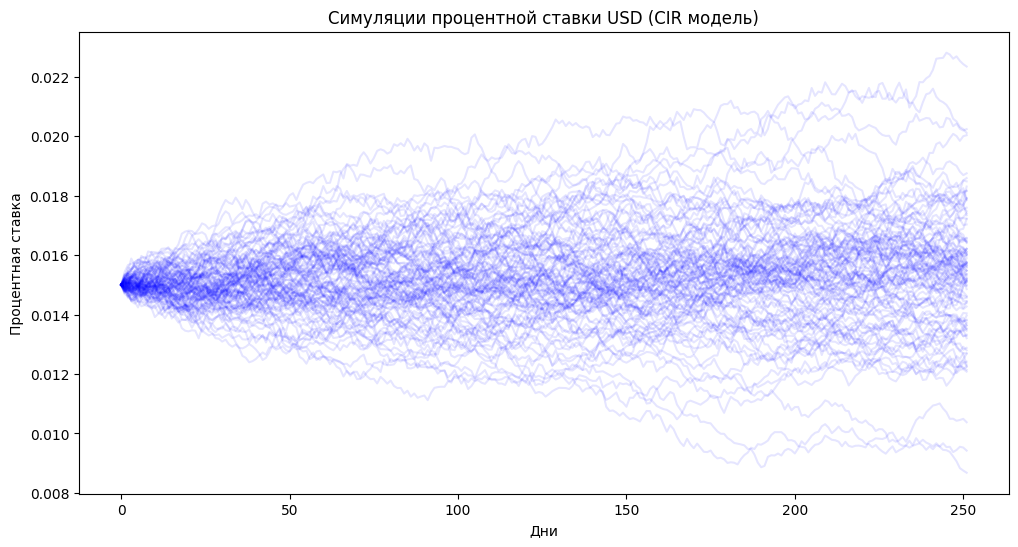

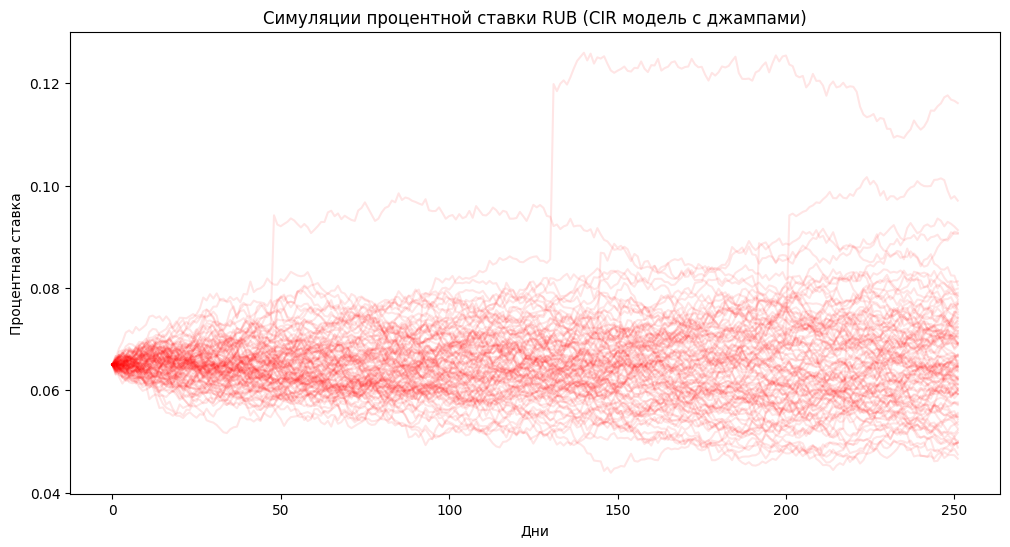

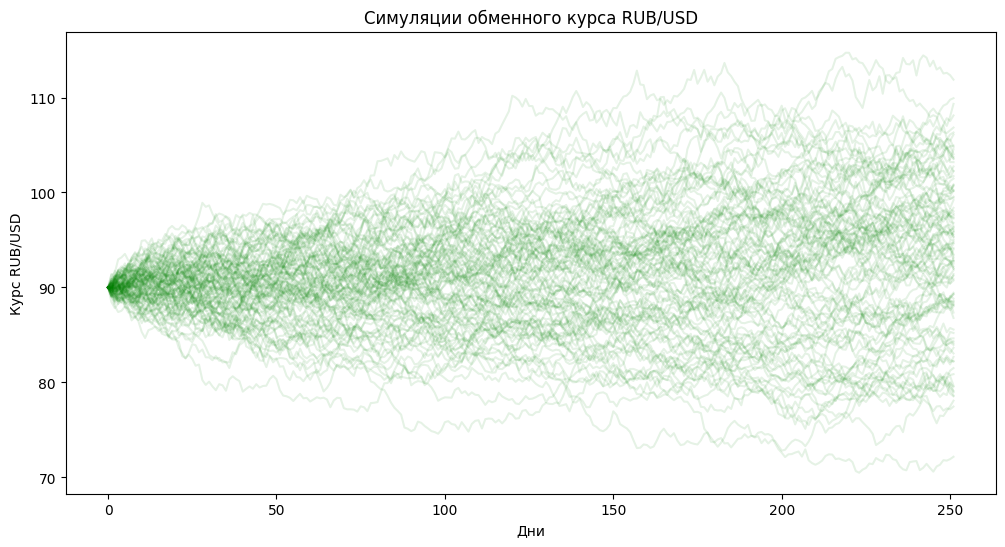

In [80]:
# Визуализация 100 случайных траекторий
sample_indices = np.random.choice(num_simulations, size=100, replace=False)

# USD ставки
plt.figure(figsize=(12, 6))
for idx in sample_indices:
    plt.plot(usd_rates_all[idx], color='blue', alpha=0.1)
plt.title('Симуляции процентной ставки USD (CIR модель)')
plt.xlabel('Дни')
plt.ylabel('Процентная ставка')
plt.show()

# RUB ставки
plt.figure(figsize=(12, 6))
for idx in sample_indices:
    plt.plot(rub_rates_all[idx], color='red', alpha=0.1)
plt.title('Симуляции процентной ставки RUB (CIR модель с джампами)')
plt.xlabel('Дни')
plt.ylabel('Процентная ставка')
plt.show()

# Обменный курс
plt.figure(figsize=(12, 6))
for idx in sample_indices:
    plt.plot(exchange_rates_all[idx], color='green', alpha=0.1)
plt.title('Симуляции обменного курса RUB/USD')
plt.xlabel('Дни')
plt.ylabel('Курс RUB/USD')
plt.show()


# Задание 2

Выплата по продукту Range Accrual рассчитывается следующим образом:

$$
\text{Payoff}_i = \text{Notional} \cdot \frac{\text{Days in Range}_i}{\text{Total Days}}
$$

Где:
- $\text{Notional}$ — номинал сделки.
- $\text{Days in Range}_i$ — количество дней, когда обменный курс находился внутри заданного диапазона для $i$-й симуляции.
- $\text{Total Days}$ — общее количество дней в периоде (например, 252 рабочих дня).

Справедливая стоимость продукта:
$$
\text{Fair Value} = \frac{1}{N} \sum_{i=1}^N \text{Payoff}_i
$$

Где:
- $N$ — общее количество симуляций.
- $\text{Payoff}_i$ — выплата для $i$-й симуляции.





In [86]:
def price_range_accrual(
    exchange_rates_all: np.ndarray,
    lower_bound: float,
    upper_bound: float,
    notional: float,
    T: float,
    N: int
) -> float:
    """
    Оценивает справедливую стоимость продукта Range Accrual

    Параметры:
    - exchange_rates_all (np.ndarray): массив всех симулированных траекторий обменного курса.
    - lower_bound (float): нижняя граница диапазона.
    - upper_bound (float): верхняя граница диапазона.
    - notional (float): номинальная стоимость продукта.
    - T (float): горизонт времени (в годах).
    - N (int): количество шагов времени.

    Возвращает:
    - fair_value (float): справедливая стоимость продукта.
    """
    dt = T / N
    in_range = np.logical_and(exchange_rates_all >= lower_bound, exchange_rates_all <= upper_bound)
    accrual_days = np.sum(in_range, axis=1)
    payoff = notional * (accrual_days * dt) / T
    fair_value = np.mean(payoff)
    return fair_value

In [75]:
# Параметры
lower_bound = 70
upper_bound = 90
notional = 1000

# Расчет справедливой стоимости
fair_value = price_range_accrual(exchange_rates_all, lower_bound, upper_bound, notional, T, N)
print(f"Справедливая стоимость Range Accrual продукта: ${fair_value:.2f}")

Справедливая стоимость Range Accrual продукта: $388.71


In [77]:
# Параметры
lower_bound = 50
upper_bound = 100
notional = 1000

# Расчет справедливой стоимости
fair_value = price_range_accrual(exchange_rates_all, lower_bound, upper_bound, notional, T, N)
print(f"Справедливая стоимость Range Accrual продукта: ${fair_value:.2f}")

Справедливая стоимость Range Accrual продукта: $879.31


In [62]:
lower_bound = 99
upper_bound = 100
notional = 1000

# Расчет справедливой стоимости
fair_value = price_range_accrual(exchange_rates_all, lower_bound, upper_bound, notional, T, N)
print(f"Справедливая стоимость Range Accrual продукта: ${fair_value:.2f}")

Справедливая стоимость Range Accrual продукта: $24.27


## **Расчет справедливой стоимости Range Accrual**

Расчет справедливой стоимости продукта показал, что его стоимость при заданных параметрах [50:100] (границы диапазона, номинал, волатильность) составила **$889.76**
Стоимость чувствительна к выбору параметров диапазона (нижней и верхней границы) и волатильности обменного курса. Чем шире диапазон, тем выше вероятность нахождения курса внутри него, что увеличивает выплату, что действительно заметно

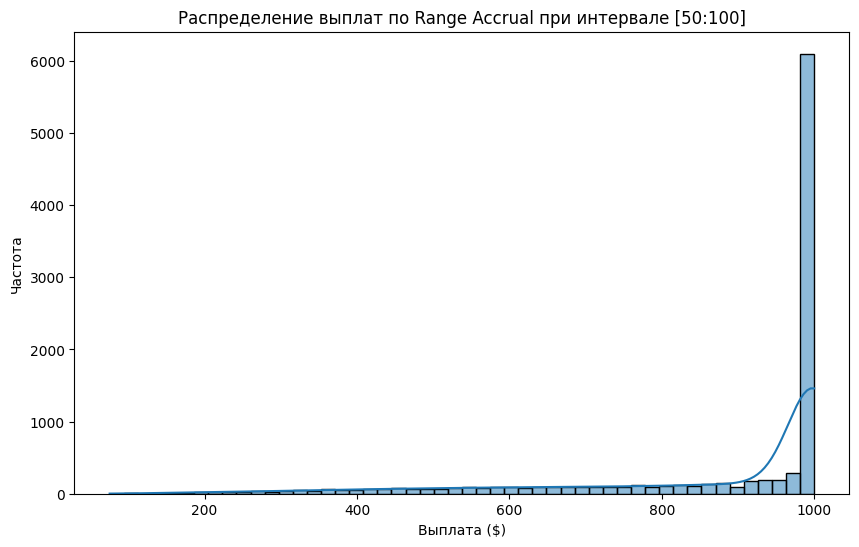

In [74]:
# Распределение выплат
payoff = notional * (np.sum(
    np.logical_and(exchange_rates_all >= lower_bound, exchange_rates_all <= upper_bound), axis=1
) * (T / N)) / T

plt.figure(figsize=(10, 6))
sns.histplot(payoff, bins=50, kde=True)
plt.title('Распределение выплат по Range Accrual при интервале [50:100]')
plt.xlabel('Выплата ($)')
plt.ylabel('Частота')
plt.show()


Вероятность нахождения в диапазоне

$P_t = \frac{1}{N} \sum_{i=1}^N \mathbb{1}[L \leq S_{t, i} \leq U]$

Средняя вероятность за весь период:
$P_{\text{avg}} = \frac{1}{T} \sum_{t=1}^T P_t$


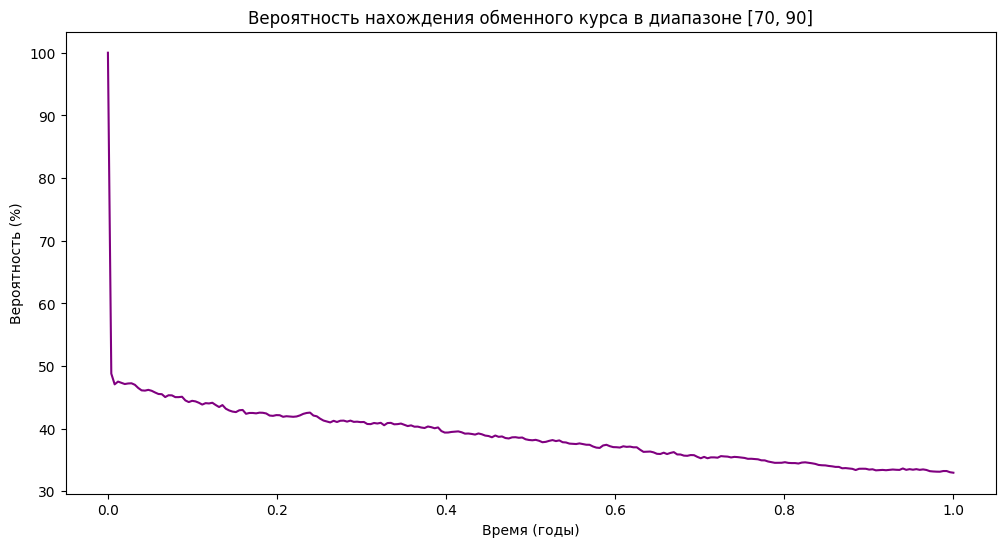

Средняя вероятность нахождения курса в диапазоне [70, 90]: 38.87%


In [76]:
# Рассчитываем вероятность нахождения курса в диапазоне на каждом шаге времени
average_in_range = np.mean(
    np.logical_and(exchange_rates_all >= lower_bound, exchange_rates_all <= upper_bound), axis=0
)

plt.figure(figsize=(12, 6))
plt.plot(np.linspace(0, T, N), average_in_range * 100, color='purple')
plt.title('Вероятность нахождения обменного курса в диапазоне [70, 90]')
plt.xlabel('Время (годы)')
plt.ylabel('Вероятность (%)')
plt.show()

# Итоговая вероятность за весь период
final_probability = np.mean(average_in_range)
print(f"Средняя вероятность нахождения курса в диапазоне [70, 90]: {final_probability * 100:.2f}%")


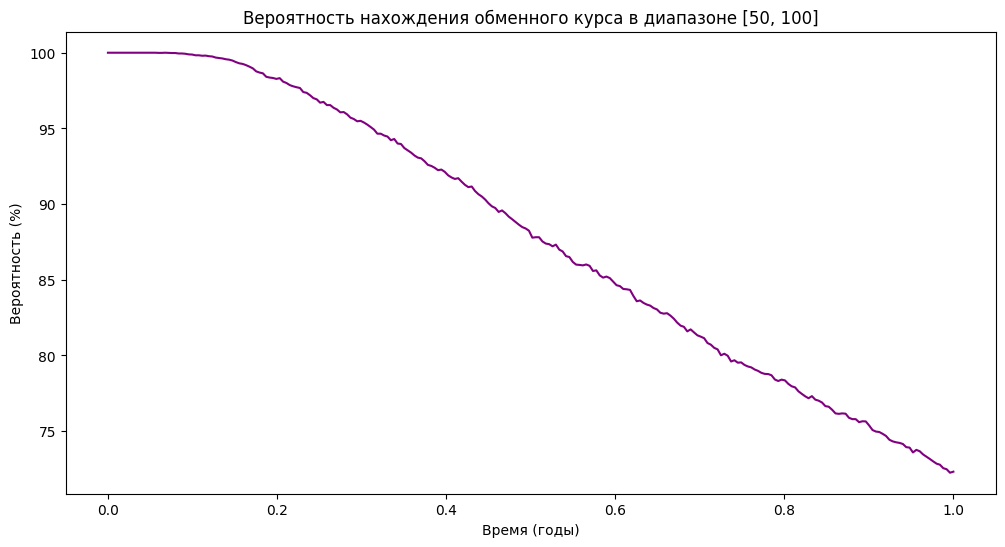

Средняя вероятность нахождения курса в диапазоне [50, 100]: 87.93%


In [78]:
# Рассчитываем вероятность нахождения курса в диапазоне на каждом шаге времени
average_in_range = np.mean(
    np.logical_and(exchange_rates_all >= lower_bound, exchange_rates_all <= upper_bound), axis=0
)

plt.figure(figsize=(12, 6))
plt.plot(np.linspace(0, T, N), average_in_range * 100, color='purple')
plt.title('Вероятность нахождения обменного курса в диапазоне [50, 100]')
plt.xlabel('Время (годы)')
plt.ylabel('Вероятность (%)')
plt.show()

# Итоговая вероятность за весь период
final_probability = np.mean(average_in_range)
print(f"Средняя вероятность нахождения курса в диапазоне [50, 100]: {final_probability * 100:.2f}%")